***
# Modele de prédiction
***

In [1]:
# ====== Importer les library ====== #
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.metrics import classification_report,  confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder


pd.set_option('display.max_columns', None)

In [2]:
# ====== Déterminer les path ====== #
import os
cwd = os.getcwd()

df_path = cwd + '\\dataframe\\'

In [6]:
# ====== Importer les df ====== #
df = pd.read_hdf(df_path + 'df_merge.h5')

df.head(2)

,IDENTITY_ATTACK,INSULT,PROFANITY,SEVERE_TOXICITY,THREAT,TOXICITY,comment_count,like_count,message_comments,mainTopic,message_posts,secondTopic,shares,title,time_difference,year,month,weekday,IDENTITY_ATTACK_cube,INSULT_cube,PROFANITY_cube,SEVERE_TOXICITY_cube,THREAT_cube,TOXICITY_cube,comment_count_cube,like_count_cube,shares_cube,messages_clean,emojis,emojis_text,positive,neutral,negative,emoji_count
0,0.102216,0.651296,0.664565,0.350583,0.029933,0.588517,0,0,"Faux, ce ne sera jamais le temps pour lui car ...",composer-preview,HÉLÈNE BUZZETTI / Jagmeet Singh a soutenu que ...,7FJ4TUHKEFEXFIZI6DY2WAQE4E,0,Les incohérences de l’ingérence,3.0,2023,6,4,0.467562,0.866814,0.872661,0.705121,0.310492,0.838017,0.0,0.0,0.0,Faux jamais temps réélu parti crève faim Jamai...,[],[],0.077610,0.130838,0.791552,0
1,0.005476,0.167515,0.255499,0.006981,0.005647,0.176317,1,1,Mon dieu!! On nous prend sérieusement pour des...,composer-preview,HÉLÈNE BUZZETTI / Jagmeet Singh a soutenu que ...,7FJ4TUHKEFEXFIZI6DY2WAQE4E,0,Les incohérences de l’ingérence,18.0,2023,6,4,0.176257,0.551253,0.634546,0.191119,0.178081,0.560745,1.0,1.0,0.0,dieu prend sérieusement idiots,[😅],[grinning_face_with_sweat],0.697028,0.047872,0.255100,1


In [7]:
df_model = df.copy()
# df_model['parent_binary'] = np.where(df_model['parent'].isna(), 0, 1)
df_model['comments_binary'] = np.where(df_model['comment_count']==0, 0, 1)

# ======= Baseline ======= #  
col_to_keep = ['IDENTITY_ATTACK', 'INSULT', 'PROFANITY', 'SEVERE_TOXICITY', 'THREAT', 'TOXICITY', 'like_count', 'shares', 'comments_binary']
# col_to_keep = ['IDENTITY_ATTACK', 'INSULT', 'PROFANITY', 'SEVERE_TOXICITY', 'THREAT', 'TOXICITY', 'like_count', 'comments_binary']


# ======= Baseline + Info supplémentaire ======= #
# col_to_keep = ['IDENTITY_ATTACK', 'INSULT', 'PROFANITY', 'SEVERE_TOXICITY', 'THREAT', 'TOXICITY', 'like_count', 'shares', 'time_difference', 'year', 'month', 'weekday', 'year', 'month', 'weekday', 'positive', 'negative', 'emoji_count', 'comments_binary']

# ======= Baseline + Info supplémentaire + standardisation ======= #
# col_to_keep = ['IDENTITY_ATTACK', 'INSULT', 'PROFANITY', 'SEVERE_TOXICITY', 'THREAT', 'TOXICITY', 'like_count', 'shares', 'time_difference', 'year', 'month', 'weekday', 'year', 'month', 'weekday', 'positive', 'negative', 'emoji_count', 'comments_binary']
# df_model[['like_count', 'shares', 'time_difference']] = StandardScaler().fit_transform(df_model[['like_count', 'shares', 'time_difference']])

# ======= Baseline + Info supplémentaire + encode time ======= #
# df_model = pd.get_dummies(df_model, columns = ['year', 'weekday'])
# col_to_keep = ['IDENTITY_ATTACK', 'INSULT', 'PROFANITY', 'SEVERE_TOXICITY', 'THREAT', 'TOXICITY', 'like_count', 'shares', 'time_difference', 'year_2020', 'year_2021', 'year_2022', 'year_2023', 'month', 'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'positive', 'negative', 'emoji_count', 'comments_binary']


# ======= Transformation score perspective ======= #
# col_to_keep = ['IDENTITY_ATTACK_cube', 'INSULT_cube', 'PROFANITY_cube', 'SEVERE_TOXICITY_cube', 'THREAT_cube', 'TOXICITY_cube', 'like_count_cube', 'shares_cube', 'time_difference', 'comments_binary']


# col_to_keep = ['IDENTITY_ATTACK_cube', 'INSULT_cube', 'PROFANITY_cube', 'SEVERE_TOXICITY_cube', 'THREAT_cube', 'TOXICITY_cube', 'like_count_cube', 'shares_cube', 'time_difference', 'year', 'month', 'weekday', 'comments_binary']
# col_to_keep = ['IDENTITY_ATTACK_cube', 'INSULT_cube', 'PROFANITY_cube', 'SEVERE_TOXICITY_cube', 'THREAT_cube', 'TOXICITY_cube', 'like_count_cube', 'shares_cube', 'time_difference', 'year', 'month', 'weekday', 'comment_count']


df_model = df_model[col_to_keep]

if  'time_difference' in col_to_keep :
    df_model['time_difference'] = np.where(df_model['time_difference']<0, 0, df_model['time_difference'])

# independent values 
col_independent = []
for col in df_model.columns.tolist():
    if col != 'comments_binary':
        col_independent.append(col)

df_model.head()

,IDENTITY_ATTACK,INSULT,PROFANITY,SEVERE_TOXICITY,THREAT,TOXICITY,like_count,shares,comments_binary
0,0.102216,0.651296,0.664565,0.350583,0.029933,0.588517,0,0,0
1,0.005476,0.167515,0.255499,0.006981,0.005647,0.176317,1,0,1
2,0.029144,0.269578,0.016753,0.006104,0.005864,0.246033,0,0,0
3,0.036105,0.402434,0.479813,0.023411,0.008220,0.372227,0,0,0
4,0.280349,0.520819,0.163573,0.169603,0.008790,0.439655,0,0,0


In [40]:
# Path : Time différence négative???
df_model['time_difference'] = np.where(df_model['time_difference']<0, 0, df_model['time_difference'])


In [7]:
# Encode
from sklearn.preprocessing import OrdinalEncoder

# test = df_model.copy()
ordinal_encoder = OrdinalEncoder()
df_model['year'] = ordinal_encoder.fit_transform(df_model[['year']])
df_model.head(2)

,IDENTITY_ATTACK,INSULT,PROFANITY,SEVERE_TOXICITY,THREAT,TOXICITY,like_count,shares,time_difference,year,month,weekday,year,month,weekday,positive,negative,emoji_count,comments_binary
0,0.102216,0.651296,0.664565,0.350583,0.029933,0.588517,0,0,3.0,3.0,6,4,3.0,6,4,0.077610,0.791552,0,0
1,0.005476,0.167515,0.255499,0.006981,0.005647,0.176317,1,0,18.0,3.0,6,4,3.0,6,4,0.697028,0.255100,1,1


In [6]:
# df_model = df_model.head(20000).copy()

In [41]:
df_model.describe()

,IDENTITY_ATTACK,INSULT,PROFANITY,SEVERE_TOXICITY,THREAT,TOXICITY,like_count,shares,time_difference,year_2020,year_2021,year_2022,year_2023,month,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,positive,negative,emoji_count,comments_binary
count,9.356980e+05,935698.000000,935698.000000,9.356980e+05,935698.000000,935698.000000,935698.000000,935698.000000,9.356980e+05,935698.000000,935698.000000,935698.000000,935698.000000,935698.000000,935698.000000,935698.000000,935698.000000,935698.000000,935698.000000,935698.000000,935698.000000,935698.000000,935698.000000,935698.000000,935698.000000
mean,1.141216e-02,0.108959,0.052533,1.360216e-02,0.010173,0.102460,1.321623,285.970075,1.836928e+03,0.375886,0.343427,0.165687,0.115000,6.344960,0.136099,0.154085,0.155424,0.151297,0.150588,0.129872,0.122635,0.371078,0.441743,0.224139,0.123964
std,4.006699e-02,0.162994,0.119968,5.610636e-02,0.035129,0.140141,5.972633,1853.642335,2.071520e+04,0.484351,0.474853,0.371800,0.319022,3.251476,0.342894,0.361030,0.362309,0.358338,0.357647,0.336163,0.328018,0.247244,0.237421,0.612577,0.329541
min,3.613072e-08,0.002280,0.000000,3.725290e-08,0.000000,0.000005,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003074,0.000853,0.000000,0.000000
25%,5.225947e-04,0.009470,0.008879,4.220009e-04,0.005321,0.008294,0.000000,7.000000,1.300000e+02,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.163835,0.259231,0.000000,0.000000
50%,1.581658e-03,0.027476,0.011270,1.215935e-03,0.005495,0.034277,0.000000,27.000000,4.910000e+02,0.000000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.323338,0.418305,0.000000,0.000000
75%,5.475683e-03,0.136078,0.022150,4.673004e-03,0.006233,0.151034,1.000000,110.000000,1.518000e+03,1.000000,1.000000,0.000000,0.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.535507,0.623939,0.000000,0.000000
max,9.491525e-01,0.973575,0.998037,9.502075e-01,0.968038,0.981763,836.000000,25872.000000,1.418885e+06,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.996014,0.988329,158.000000,1.000000


***
### Fonction
***

In [32]:
def modelScore(y_test, y_prediction):
    tn, fp, fn, tp = confusion_matrix(y_test, y_prediction).ravel()
    
    evaluation = round(tp / (tp+fp+fn), 2)
    print(f"Évaluation : {evaluation}")

    accuracy = accuracy_score(y_test, y_prediction)
    print(f"Accuracy: {accuracy:.2f}")

    precision = precision_score(y_test, y_prediction)
    print(f"Precision: {precision:.2f}")

    recall = recall_score(y_test, y_prediction)
    print(f"Recall: {recall:.2f}")

    f1 = f1_score(y_test, y_prediction)
    print(f"f1_score: {f1:.2f}")


def featureImportance(classifier, X_test, y_test):
    feature_names = X_test.columns
    imps = permutation_importance(classifier, X_test, y_test)
    feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': imps.importances_mean})
    feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)
    print("\nFeature Importance:\n", feature_importance_df)
    # https://scikit-learn.org/stable/modules/permutation_importance.html#permutation-importance


def confusionMatricePlot(y_test, y_prediction):
    cm = confusion_matrix(y_test, y_prediction)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()


def durationTime(start_time, end_time):
    duration = round((end_time - start_time) / 60, 2)
    print(f'Running time : {duration} min')

***
### Logit
***

In [55]:
df_model.head(2)

In [29]:
# https://www.statsmodels.org/stable/generated/statsmodels.discrete.discrete_model.Probit.html#statsmodels.discrete.discrete_model.Probit
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression

start_time = time.time()

X = df_model[col_independent]
y = df_model['comments_binary']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=104, test_size=0.25, shuffle=True) 

# X, y = load_iris(return_X_y=True)
# classifier = LogisticRegression(random_state=0).fit(X_train, y_train)
classifier = LogisticRegression(random_state=0, class_weight='balanced', max_iter=500).fit(X_train, y_train)


y_prediction = classifier.predict(X_test)
end_time = time.time()

# Standardiser les valeurs

In [33]:
modelScore(y_test, y_prediction)
durationTime(start_time, end_time)

Évaluation : 0.22
Accuracy: 0.81
Precision: 0.31
Recall: 0.42
f1_score: 0.36
Running time : 0.02 min


***
### Binomial négative
***

In [9]:
import statsmodels.api as sm
# https://www.statsmodels.org/stable/generated/statsmodels.discrete.discrete_model.NegativeBinomial.html#statsmodels.discrete.discrete_model.NegativeBinomial
# Fit the negative binomial regression model

X = df_model[col_independent]
y = df_model['comments_binary']


model = sm.GLM(y, X, family=sm.families.NegativeBinomial())
result = model.fit()

# Print summary of the regression results
print(result.summary())

C:\Users\Charles_tour\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


                 Generalized Linear Model Regression Results                  
Dep. Variable:        comments_binary   No. Observations:                20000
Model:                            GLM   Df Residuals:                    19986
Model Family:        NegativeBinomial   Df Model:                           13
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -7531.4
Date:                Mon, 01 Apr 2024   Deviance:                       8070.2
Time:                        23:52:45   Pearson chi2:                 1.78e+04
No. Iterations:                   100   Pseudo R-squ. (CS):            0.03590
Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
IDENTITY_ATTACK     3.2969      0.943     

***
### Random forest
***

In [24]:
# Code pour optimiser les hyperparamètres
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split
import numpy as np

# X = df_model[col_to_keep]
# y = df_model['comments_binary']

# param_dist = {
#     'n_estimators': np.random.randint(100, 500, 10),
#     'max_depth': [None] + list(np.linspace(3, 20, 5).astype(int)),
#     'min_samples_split': list(range(2, 21, 2)),
#     'min_samples_leaf': list(range(1, 21, 2)),
#     'max_features': ['sqrt', 'log2', None]
# }

# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=104, test_size=0.25, shuffle=True) 

# random_search = RandomizedSearchCV(
#     RandomForestClassifier(),
#     param_distributions=param_dist,
#     n_iter=20,
#     cv=5,
#     scoring='accuracy',
#     n_jobs=-1,
#     random_state=42
# )

# random_search.fit(X_train, y_train)

# print("Best hyperparameters:", random_search.best_params_)

# # Create a new Random Forest with the best hyperparameters
# best_rf = random_search.best_estimator_

# # Evaluate the best model on the test set
# test_accuracy = best_rf.score(X_test, y_test)
# print(f"Test accuracy: {test_accuracy:.2f}")


Best hyperparameters: {'n_estimators': 383, 'min_samples_split': 14, 'min_samples_leaf': 19, 'max_features': None, 'max_depth': 11}
Test accuracy: 0.89


In [19]:
# df_model = df_model.head(10000).copy()

In [12]:
from sklearn.ensemble import RandomForestClassifier

start_time = time.time()

X = df_model[col_independent]
y = df_model['comments_binary']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=104, test_size=0.25, shuffle=True) 

classifier = RandomForestClassifier(n_estimators=383, min_samples_split=14, min_samples_leaf=19, max_features=None, max_depth=11)
classifier.fit(X_train, y_train)

y_prediction = classifier.predict(X_test)

end_time = time.time()

In [11]:
# Test********

# from concurrent.futures import ThreadPoolExecutor
# import concurrent.futures

# def train_model(X_train, y_train):
#     classifier = RandomForestClassifier(n_estimators=383, min_samples_split=14, min_samples_leaf=19, max_features=None, max_depth=11)
#     classifier.fit(X_train, y_train)
#     return classifier

# def predict(classifier, X_test):
#     return classifier.predict(X_test)

# with concurrent.futures.ThreadPoolExecutor(max_workers=8) as executor:
#     X = df_model[col_independent]
#     y = df_model['comments_binary']
#     X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=104, test_size=0.25, shuffle=True)

#     train_future = executor.submit(train_model, X_train, y_train)
#     classifier = train_future.result()

#     predict_future = executor.submit(predict, classifier, X_test)
#     y_prediction = predict_future.result()

In [13]:
modelScore(y_test, y_prediction)
durationTime(start_time, end_time)

Accuracy: 0.88
Precision: 0.68
Recall: 0.14
f1_score: 0.23
Running time : 43.21 min


In [14]:
featureImportance(classifier, X_test, y_test)

# with concurrent.futures.ThreadPoolExecutor(max_workers=8) as executor:
#     feature_importance_future = executor.submit(featureImportance, classifier, X_train, y_test)


Feature Importance:
             feature    importance
6        like_count  2.084771e-02
8   time_difference  2.551245e-03
0   IDENTITY_ATTACK  1.467137e-03
4            THREAT  9.199530e-04
7            shares  5.890777e-04
1            INSULT  5.087101e-04
5          TOXICITY  4.257775e-04
22         negative  2.966763e-04
2         PROFANITY  2.710270e-04
3   SEVERE_TOXICITY  1.265363e-04
21         positive  5.471839e-05
15             year  4.958854e-05
16             year  4.958854e-05
9              year  4.958854e-05
10             year  4.958854e-05
14          weekday  3.676392e-05
13          weekday  3.676392e-05
19          weekday  3.676392e-05
20          weekday  3.676392e-05
12            month  5.129849e-06
18            month  5.129849e-06
17            month  5.129849e-06
11            month  5.129849e-06
23      emoji_count -8.549749e-07


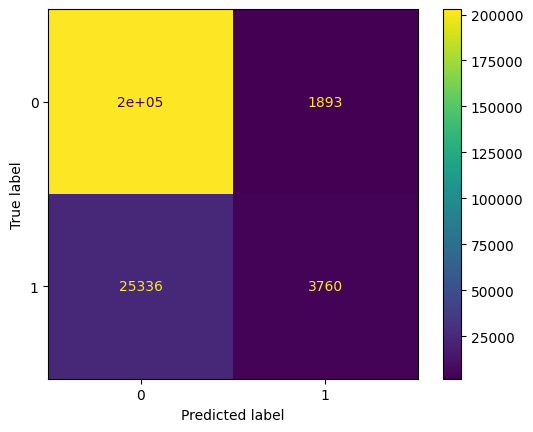

In [55]:
confusionMatricePlot(y_test, y_prediction)

***
### Naive Bayes
***

In [53]:
from sklearn.inspection import permutation_importance
from sklearn.naive_bayes import MultinomialNB

start_time = time.time()

X = df_model[col_independent]
y = df_model['comments_binary']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=142, test_size=0.25, shuffle=True, )

classifier = MultinomialNB(alpha=1)
classifier.fit(X_train, y_train)
y_prediction = classifier.predict(X_test)

end_time = time.time()

In [54]:
modelScore(y_test, y_prediction)
durationTime(start_time, end_time)

Évaluation : 0.22
Accuracy: 0.81
Precision: 0.31
Recall: 0.43
f1_score: 0.36
Running time : 0.0 min


In [59]:
featureImportance(classifier, X_test, y_test)


Feature Importance:
            feature    importance
8  comments_binary  1.446258e-01
6       like_count  2.358106e-02
4           THREAT  1.538955e-05
0  IDENTITY_ATTACK  8.549749e-07
5         TOXICITY -1.709950e-06
1           INSULT -3.419900e-06
3  SEVERE_TOXICITY -3.419900e-05
2        PROFANITY -5.215347e-05
7           shares -8.216309e-03


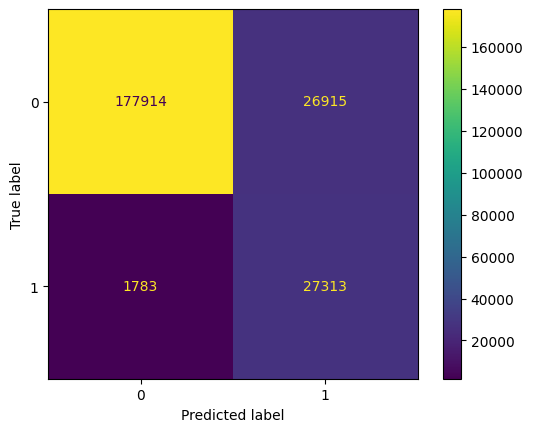

In [60]:
confusionMatricePlot(y_test, y_prediction)

***
SVC
***

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC

start_time = time.time()

X = df_model[col_independent]
y = df_model['comments_binary']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=142, test_size=0.25, shuffle=True, )

classifier = make_pipeline(StandardScaler(), SVC(gamma='auto'))
classifier.fit(X_train, y_train)
y_prediction = classifier.predict(X_test)

end_time = time.time()

***
### Gradient-Boosting
***

In [49]:
from sklearn.ensemble import GradientBoostingClassifier

start_time = time.time()

X = df_model[col_independent]
y = df_model['comments_binary']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.25, shuffle=True)

classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0, min_samples_split=2).fit(X_train, y_train)
classifier.score(X_test, y_test)

y_prediction = classifier.predict(X_test)
end_time = time.time()

In [50]:
modelScore(y_test, y_prediction)
durationTime(start_time, end_time)

Évaluation : 0.11
Accuracy: 0.88
Precision: 0.64
Recall: 0.12
f1_score: 0.21
Running time : 0.49 min


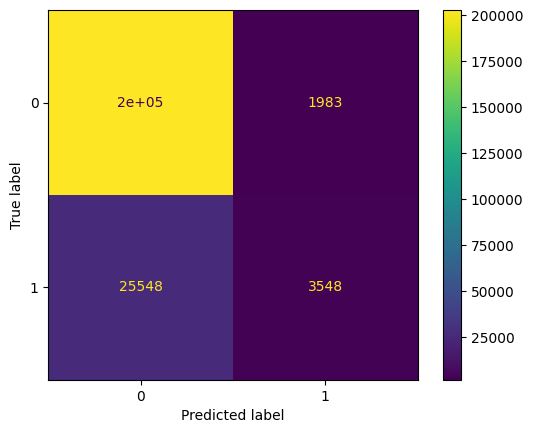

In [14]:
confusionMatricePlot(y_test, y_prediction)

***
Neural network
***

In [42]:
from sklearn.neural_network import MLPClassifier

start_time = time.time()


X = df_model[col_independent]
y = df_model['comments_binary']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=104, test_size=0.25, shuffle=True, stratify=y)

classifier = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
classifier.fit(X, y)

y_prediction = classifier.predict(X_test)

end_time = time.time()

In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier

# Define parameter grid
param_grid = {
    'hidden_layer_sizes': [(10,), (20,), (30,)],
    'alpha': [0.0001, 0.001, 0.01],
    'solver': ['adam', 'lbfgs'],
    'max_iter': [100, 200, 300]
}

# Create MLPClassifier instance
classifier = MLPClassifier(random_state=1)

# Grid search cross-validation
grid_search = GridSearchCV(classifier, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Print best parameters and best score
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

C:\Users\Charles_tour\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Charles_tour\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lb

In [43]:
modelScore(y_test, y_prediction)
durationTime(start_time, end_time)

Évaluation : 0.0
Accuracy: 0.88
Precision: 0.00
Recall: 0.00
f1_score: 0.00
Running time : 0.03 min


C:\Users\Charles_tour\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


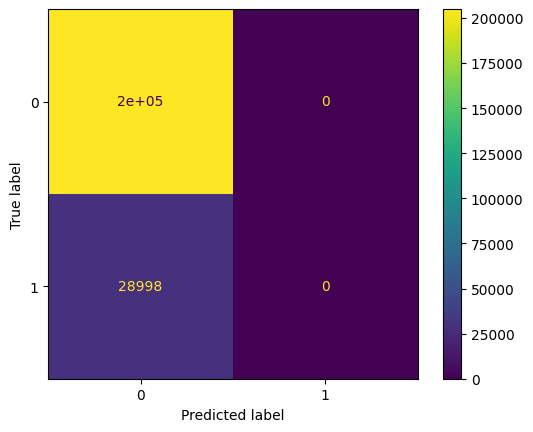

In [16]:
confusionMatricePlot(y_test, y_prediction)

***
K Mean
***

In [47]:
from sklearn.cluster import KMeans

X = df_model[col_independent]
y = df_model['comments_binary']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=104, test_size=0.25, shuffle=True, stratify=y)

kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(X)

y_prediction = kmeans.predict(X_test)

end_time = time.time()

In [48]:
modelScore(y_test, y_prediction)
durationTime(start_time, end_time)

Évaluation : 0.0
Accuracy: 0.87
Precision: 0.09
Recall: 0.00
f1_score: 0.01
Running time : 2.3 min


***
Ensemble de modèle
***

In [55]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

start_time = time.time()

X = df_model[col_independent]
y = df_model['comments_binary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model1 = LogisticRegression()
model2 = RandomForestClassifier()
model3 = SVC()

ensemble_model = VotingClassifier(estimators=[('lr', model1), ('rf', model2), ('svc', model3)], voting='hard')

ensemble_model.fit(X_train, y_train)

y_prediction = ensemble_model.predict(X_test)

end_time = time.time()

In [56]:
modelScore(y_test, y_prediction)
durationTime(start_time, end_time)

Évaluation : 0.08
Accuracy: 0.88
Precision: 0.73
Recall: 0.08
f1_score: 0.15
Running time : 466.5 min


***
Visualisation
***

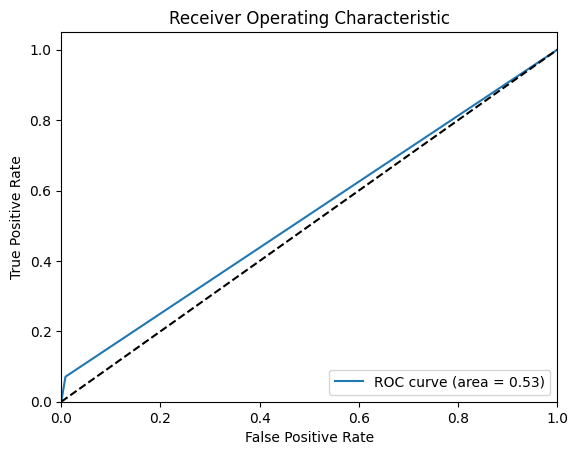

In [88]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, y_prediction)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()